# Universal reservoir: sampling a fixed number of elements from unbounded data

How would you draw a fixed sample size from a set? You might randomly choose indices in the range of the size of the set, then select the corresponding elements. What if your set is too big to hold all at once? If you know the size of your set, you can determine the sample fraction and sample with it.

But what if you don't know the size of your set? Or it's so large that getting an exact answer is complicated enough?

The concept of drawing a fixed number of elements from unbounded data is known as [reservoir sampling](https://en.wikipedia.org/wiki/Reservoir_sampling). Reservoir techniques provide statistically sound random samples in a single pass with no requirement of _a priori_ knowledge of the size of a sample.

In [an earlier post](/2023/02/13/universal-sampling/), I covered universal sampling: the use of a universal hash function to make decisions about which elements to choose. In this post, I will cover the universal reservoir: the use of a universal hash function to create a universal sampling procedure.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.dataset as ds

from sklearn.utils.murmurhash import (
    murmurhash3_32 as _murmurhash3_32,
)
from timeit import timeit
from tqdm.notebook import tqdm
from typing import Iterable

INT_MIN = np.int32(-(2**31))
INT_MAX = np.int32(2**31 - 1)
INT_RANGE = np.int64(2**32)

random_state = np.random.RandomState(8675309)


def murmurhash(values):
    """Wrapper for sklearn's MurmurHash that accepts most argument types"""
    if np.ndim(values):
        if np.issubdtype(values.dtype, np.int32):
            return _murmurhash3_32(values)
        return _mmhash_ufunc(values.astype(np.bytes_)).astype(
            np.int32
        )
    if isinstance(values, (bytes, str, np.int32)):
        return _murmurhash3_32(values)
    return _mmhash_ufunc(np.array(values, dtype=np.bytes_))


_mmhash_ufunc = np.frompyfunc(_murmurhash3_32, nin=1, nout=1)

## Why should we use hash functions for reservoir sampling?

Traditional reservoir sampling algorithms work when both of these conditions are met:

1. Inputs are independent. For example, simple random sampling of rows or multistage sampling from deduplicated data. 
2. The desired sample size is small enough to efficiently hold in memory

This conditions are very restrictive in practice. For example, we might want to sample devices from a large stream of advertising data for realtime monitoring and reporting on many different metrics (e.g., by client).

1. The data are not independent. We must deduplicate and detect new devices prior to building the reservoir sampling.
2. The true sample size is quickly infeasible; it's (sample size per metric) $\times$ (number of metrics). We then find ourselves creating many different reservoirs and streams.

Universal hash functions mitigate these issues. These functions efficiently and deterministically map inputs to uniformly distributed integers. 

1. Hash values are the same each time we see a device, so the original stream can be used directly to build a reservoir.
2. We don't need to hold the entire reservoir state in memory, so we can easily scale the sample up to the size of the original data.

Additional benefits include
* insensitivity to data order
* identical approach for different sampling schemes (e.g., simple random sampling and block sampling)
* usable for in-memory data, distributed datasets, batch/minibatch updates, and single-event streams

## A gentle introduction

We start with a small set of values.

In [2]:
set_size = 10**4
sample_size = 10

small_set = np.arange(set_size)
random_state.shuffle(small_set)

With small, fixed sets, there is no issue choosing a fixed number of elements.

In [3]:
sample = random_state.choice(
    small_set, sample_size, replace=False
)
sample

array([7015, 4608, 5702, 8678, 2247, 1009, 4134, 6790, 8089, 8914])

We can leverage the properties of universal hash functions to do this as well. Hash values are uncorrelated with inputs and are orderable. This means we can choose elements based on their hash order statistics.

In [4]:
hash_order = np.argsort(murmurhash(small_set))
small_set[hash_order < sample_size]

array([ 693, 6495, 3449, 1432,  143, 9687, 2545, 3638, 7704, 7086])

## A more practical demonstration

The value of reservoir sampling is dealing with unbounded data. We simply need to maintain a set up to our sample size that contains the smallest hash values we've seen. This is most naturally represented as a sorted set. We sample from our inputs with hash values smaller than the $k$th hash in our state (the maximum hash value in our truncated set).

In [5]:
class HashReservoir:
    """Simple reservoir of hashes

    Parameters
    ----------
    sample_size : int
        Target size of the reservoir
    """

    def __init__(self, sample_size: int):
        self.sample_size = sample_size
        self.hashes = (
            np.zeros(self.sample_size, dtype=np.int32) + INT_MAX
        )

    def update(self, new_hashes: Iterable[int]):
        """Update the sorted set of hashes"""
        new_hashes = np.setdiff1d(new_hashes, self.hashes)[
            : self.sample_size
        ]
        insertion_points = np.searchsorted(
            self.hashes, new_hashes
        )
        self.hashes[:] = np.insert(
            self.hashes, insertion_points, new_hashes
        )[: self.sample_size]
        return self

    @property
    def kth_hash(self):
        return self.hashes[-1]

    def __repr__(self):
        return (
            f"HashReservoir(sample_size={self.sample_size},"
            f" kth_hash={self.kth_hash})"
        )

In [6]:
sample_size = 2**12
hash_reservoir = HashReservoir(sample_size)

set_size = 10**6
minibatch_size = 10**3
minibatches = set_size // minibatch_size
values = random_state.uniform(size=set_size)

# just for analysis later
states = (
    np.zeros((minibatches, sample_size), dtype=np.int32)
    + INT_MAX
)

for i, minibatch in enumerate(np.split(values, minibatches)):
    hashes = murmurhash(minibatch)
    hash_reservoir.update(hashes)
    states[i] = hash_reservoir.hashes

hash_reservoir

HashReservoir(sample_size=4096, kth_hash=-2129643907)

Interestingly, our hash reservoir has also provided a [reasonable solution to the count-distinct problem](https://en.wikipedia.org/wiki/Count-distinct_problem#Bottom-m_sketches). Our $k$th hash is an estimate of the sample rate from the set of all processed hashes. This is the inverse estimator for the number of distinct elements we've seen. Our relatively small set gives us a relatively small error.

In [7]:
def _sample_rate(self):
    if self.kth_hash < 0:
        return -(INT_MIN - self.kth_hash) / INT_RANGE
    if self.kth_has < INT_MAX:
        return self.kth_hash / INT_MAX / 2 + 0.5
    return 1.0


def _nunique(self):
    if self.kth_hash < INT_MAX:
        return self.sample_size / self.sample_rate
    return float(len(self.hashes))


HashReservoir.sample_rate = property(_sample_rate)
HashReservoir.nunique = property(_nunique)

hash_reservoir.nunique, np.log(hash_reservoir.nunique / set_size)

(986123.3996847824, -0.013973780400211978)

Visualizing the state helps explain the sampling process. 
* In the first plot, we see the cumulative sample rate continually decreasing as the nubmer of distinct inputs increases in log-log fashion. 
* In the second, we see how the reservoir immediately and greedily fills, then old values are removed as we incorporate new inputs while maintaining that sample rate.

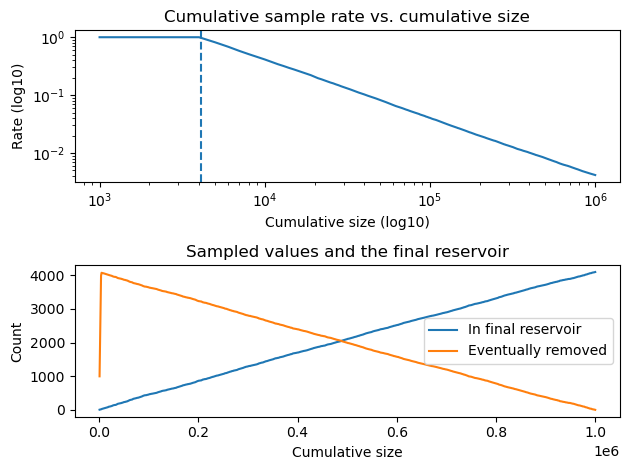

In [8]:
cumulative_size = (np.arange(minibatches) + 1) * minibatch_size
kth_hashes = states[:, -1]
_ = kth_hashes[-1] < states
eventually_removed = (_ & (states < INT_MAX)).sum(axis=1)
in_final_reservoir = (~_ & (states < INT_MAX)).sum(axis=1)

sample_rates = np.where(
    kth_hashes < INT_MAX,
    np.where(
        kth_hashes < 0,
        -(INT_MIN - kth_hashes) / INT_RANGE,
        kth_hashes / INT_MAX / 2 + 0.5,
    ),
    1.0,
)

fig, ax = plt.subplots(nrows=2)

ax[0].plot(cumulative_size, sample_rates)
ax[0].axvline(sample_size, ls="--")
ax[0].set(
    title="Cumulative sample rate vs. cumulative size",
    xscale="log",
    yscale="log",
    xlabel="Cumulative size (log10)",
    ylabel="Rate (log10)",
)

ax[1].plot(
    cumulative_size,
    in_final_reservoir,
    label="In final reservoir",
)
ax[1].plot(
    cumulative_size,
    eventually_removed,
    label="Eventually removed",
)
ax[1].set(
    title="Sampled values and the final reservoir",
    xlabel="Cumulative size",
    ylabel="Count",
)
ax[1].legend()

fig.tight_layout();

## What if I need to take a much larger sample?

My friend, it's turtles all the way down.

As demonstrated above, we get a relatively good estimate of the number of unique values from a relatively small set. That means we can approximate the $k$th hash using a relatievly small hash reservoir.

(No, there is nothing special about using a reservoir to estimate the number of unique values other than common implementation and ease of inspection. You could just as easily use HyperLogLog or whatever, subject to your particular restrictions.)

In [9]:
class ApproximateKth:
    """Simple approximation of kth hash value in a large set

    Parameters
    ----------
    sample_size : int
        Target size of the sample
    reservoir_size : int
        Size of the reservoir used to approximate our larger sample_size
    """

    def __init__(self, sample_size: int, reservoir_size: int):
        self.sample_size = sample_size
        self.reservoir_size = reservoir_size
        self.reservoir = HashReservoir(self.reservoir_size)

    def update(self, new_hashes: Iterable[int]):
        self.reservoir.update(new_hashes)
        return self

    @property
    def kth_hash(self):
        nunique = self.reservoir.nunique
        if nunique < self.sample_size:
            return INT_MAX
        inverse, remainder = divmod(
            INT_MIN + self.sample_size / nunique * INT_RANGE, 1
        )
        return int(inverse) + (remainder > 0)

    sample_rate = property(_sample_rate)
    nunique = property(_nunique)

    def __repr__(self):
        return (
            f"ApproximateKth(sample_size={self.sample_size},"
            f" kth_hash={self.kth_hash},"
            f" reservoir={self.reservoir})"
        )

We can test the efficiency and accuracy of this approach relative to an "exact" reservoir with a large-but-not-too-large sample size. In this single test, we approximate the $k$th hash with trivial error but about 24 times faster. The computational gains increase as sample size increases. In adtech, for example, there may be use cases for a sample size in the _billions_ (in which case you need to use a 64-bit hash function!).

In [10]:
sample_size = 10**7
reservoir_size = 2**12

reservoir = HashReservoir(sample_size)
approx = ApproximateKth(sample_size, reservoir_size)

minibatch_size = 10**5
minibatches = sample_size // minibatch_size
reservoir_time, approx_time = 0, 0

for batch in tqdm(range(minibatches), leave=False):
    values = random_state.uniform(size=minibatch_size)
    hashes = murmurhash(values)
    reservoir_time += timeit(
        lambda: reservoir.update(hashes), number=1
    )
    approx_time += timeit(
        lambda: approx.update(hashes), number=1
    )

np.log(
    reservoir.kth_hash / approx.kth_hash
), reservoir_time / approx_time

  0%|          | 0/100 [00:00<?, ?it/s]

(0.0, 23.63257755196555)

## Wrapping up

The unviversal reservoir (universal hashing + reservoir sampling) is straightforward to implement. It is subject to few restrictions that makes it useful for applied work, especially as we increase the volume or velocity of input data.

In a following post, I will demonstrate a worked example of reservoir sampling for answering approximate queries in true real-time.